In [1]:
! pip install "ray[data]==2.2.0"

In [22]:
import ray

ds = ray.data.range(10000)
print(ds.count())
print(ds.schema())
print(ds.take(5))

10000
<class 'int'>
[0, 1, 2, 3, 4]


In [23]:
print(ds.take(20))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


## 读写dataset

In [26]:
ray.data.range(10000).write_csv("demofile")

Write Progress: 100%|██████████| 49/49 [00:00<00:00, 10168.76it/s]


In [35]:
new_ds = ray.data.read_csv("demofile")
print(new_ds.count())
print(new_ds.num_blocks())

Read progress: 100%|██████████| 48/48 [00:00<00:00, 66.70it/s]

10000
48


### DataSet的常见操作

In [ ]:
ds1 = ray.data.range(1000)
ds2 = ray.data.range(1000)
ds3 = ds1.union(ds2)
print(ds3.count())

In [32]:
ds3 = ds3.filter(lambda x:x %2 == 0)
print(ds3.take(5))

2024-06-30 23:24:26,550	WARNING dataset.py:4233 -- The `map`, `flat_map`, and `filter` operations are unvectorized and can be very slow. Consider using `.map_batches()` instead.
Read->Filter: 100%|██████████| 100/100 [00:00<00:00, 596.87it/s]

[0, 2, 4, 6, 8]


In [33]:
ds3 = ds3.sort()
print(ds3.take(5))

Shuffle Reduce: 100%|██████████| 100/100 [00:00<00:00, 392.36it/s]

[0, 0, 2, 2, 4]


## 数据块与重新分区
数据块是dataset分布式处理数据的核心，块过多的话每个块太小每个操作的开销就会很大，块如果过少，操作的并行化的效率无法得到有效提升。  因此适当情况下我们有时候需要重新调整分区大小，确保数据块的数据大小在一定空间.

数据块还有一个重要的作用的就是改变写入存储时创建的文件数，比如我们期望所有数据合并成一个文件写入到存储中，而不是写入非常多的分片

In [34]:
print(ds3.num_blocks())

100


In [37]:
ds3 = ds3.repartition(10)
print(ds3.num_blocks())
print(ds3.take(10))

Repartition: 100%|██████████| 10/10 [00:00<00:00, 748.84it/s]

10
[0, 0, 2, 2, 4, 4, 6, 6, 8, 8]



Read progress:  90%|████████▉ | 43/48 [41:51<04:52, 58.42s/it]


In [42]:

ray.data.range(10000).repartition(2).write_csv("onefile")

ds4 = ray.data.read_csv("onefile")

print(ds4.num_blocks())

Write Progress: 100%|██████████| 2/2 [00:00<00:00, 319.24it/s]
2024-06-30 23:38:28,733	WARNING read_api.py:326 -- ⚠️  The number of blocks in this dataset (2) limits its parallelism to 2 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.


2


## 查看Ray的可用资源数
available_resources = ray.available_resources()
print("Available CPUs:", available_resources.get("CPU", 0))。  在linux中也可以通过lscpu来进行查看机器的核数，我们看到ray获取的和机器的逻辑核数是一致的
机器的结果
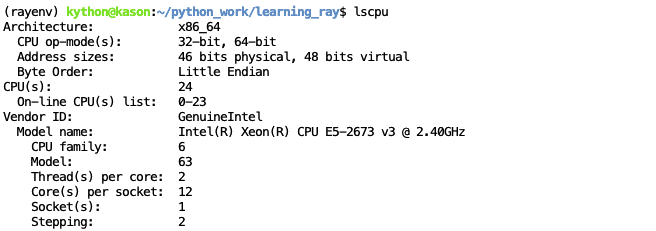
ray获取的结果
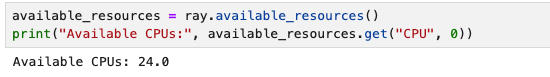

In [43]:
available_resources = ray.available_resources()
print("Available CPUs:", available_resources.get("CPU", 0))

Available CPUs: 24.0


In [47]:
ray.data.range(10000).repartition(int(available_resources.get("CPU", 0))).write_csv("onefile_new")

ds4 = ray.data.read_csv("onefile_new")

print(ds4.num_blocks())

Write Progress: 100%|██████████| 24/24 [00:00<00:00, 3119.89it/s]

24


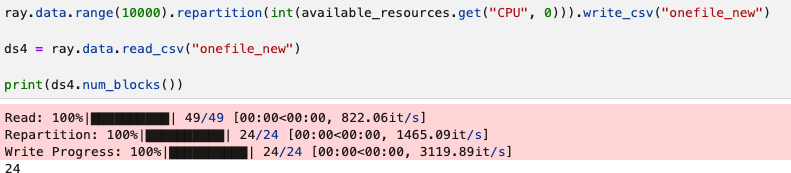

可以看到默认的数据分区块是49块，后面通过repartition将其调整成和我们的机器能获取的可用的cpu数目一致，也就是本环境中的24.

## dataset模式
Dataset支持Arrow的列示格式，它可以在Python字典、DataFrame和序列化的Parquet文件等不同数据类型之间进行交换。举例如下

In [6]:
# 通过字典创建Dataset
ds = ray.data.from_items([{"id":1,"value":"abc"},{"id":123,"value":"rtgh"}])
print(ds.schema())

# 把dataset 转为pands
pandas_df = ds.to_pandas()
print(pandas_df)
# 通过pandas转为字典，一行代表一个字典
dict_df = data_dict = pandas_df.to_dict(orient='records')
print(data_dict)

id: int64
value: string
    id value
0    1   abc
1  123  rtgh
[{'id': 1, 'value': 'abc'}, {'id': 123, 'value': 'rtgh'}]


pandas 转为 Dataset， 一种数据量不是很大的可以直接进行转换，另一种可能pandas非常大，需要分片进行处理再合并成dataset

In [9]:
import pandas as pd

df = pd.DataFrame({"id":[1,2,3,4], "value":["abc","sdf","errt","opppo"]})
print(df)
ds = ray.data.from_pandas(df)
print(ds.take())

   id  value
0   1    abc
1   2    sdf
2   3   errt
3   4  opppo
[{'id': 1, 'value': 'abc'}, {'id': 2, 'value': 'sdf'}, {'id': 3, 'value': 'errt'}, {'id': 4, 'value': 'opppo'}]
